In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import datetime
import re
import os

# Function to retrieve grid specs

In [2]:
def return_grid_specs(path):
    
    df = pd.read_csv(path)
    col_name = df.columns[0]
    ncols_line = df.columns[0]
    nrows_line = df[col_name][0]
    xmin_line = df[col_name][1]
    ymin_line = df[col_name][2]
    size_line = df[col_name][3]

    x_n = int(ncols_line.split()[-1])
    y_n = int(nrows_line.split()[-1])
    x_min = int(float(xmin_line.split()[-1]))
    y_min = int(float(ymin_line.split()[-1]))
    cell_size = int(float(size_line.split()[-1]))

    x = np.arange(x_min, x_min + cell_size * x_n, cell_size) / 1000
    y = np.arange(y_min, y_min + cell_size * y_n, cell_size) / 1000

    return x, y

# Get data

In [3]:
# Load arrays
year = "1980" # e.g. "1980"
month = "01" # e.g. "01"
day = "01" # e.g. "01"
hour = "01" # e.g. "01"
timestamp = year + month + day + hour + "00"
time_str = year + "-" + month + "-" + day + "T" + hour + ":" + hour
wn_in_path = "/scratch/summit/erke2265/antarctic-windninja/PIG/" + timestamp + "/input/" + timestamp + "_vel.asc"
wn_out_path = "/scratch/summit/erke2265/antarctic-windninja/PIG/" + timestamp + "/output/PIG_1000m_vel.asc"
wn_processed_path = "/scratch/summit/erke2265/antarctic-windninja/PIG/processed_output/" + timestamp + "00_VW.asc"

wn_in = np.flipud(np.loadtxt(wn_in_path, skiprows=6))
wn_out = np.flipud(np.loadtxt(wn_out_path, skiprows=6))
wn_processed = np.flipud(np.loadtxt(wn_processed_path, skiprows=6))

# Return grid specs
x, y = return_grid_specs(wn_in_path)
wn_x, wn_y = return_grid_specs(wn_out_path)
wn_processed_x, wn_processed_y = return_grid_specs(wn_processed_path)

# Find max min
# maxima = np.maximum(wn_in.max(), wn_out.max())
# minima = np.minimum(wn_in.min(), wn_out.min())
maxima = wn_processed.max()
minima = wn_processed.min()
print("Maxima = " + str(maxima))
print("Minima = " + str(minima))

Maxima = 6.230000019073486
Minima = 3.2200000286102295


# MERRA-2

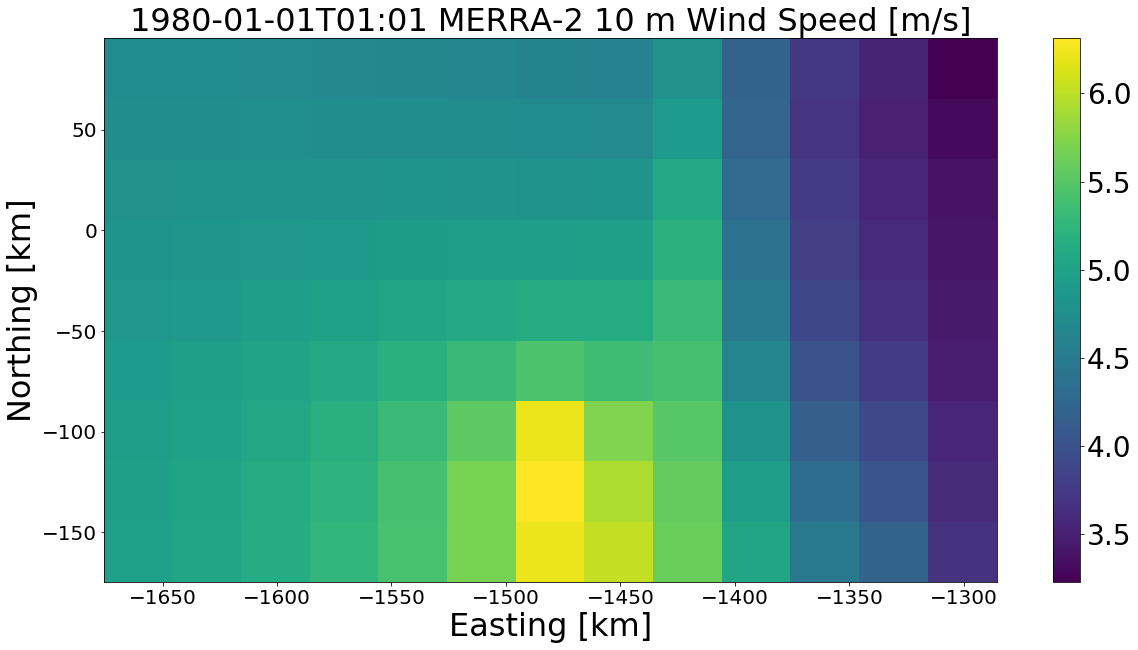

In [4]:
plt.figure(figsize=(20, 10))
# plt.pcolor(x, y, wn_in, vmin=minima, vmax=maxima)
plt.pcolor(x, y, wn_in)
cb = plt.colorbar()
# plt.xlim([wn_x.min(), wn_x.max()])
# plt.ylim([wn_y.min(), wn_y.max()])
cb.ax.tick_params(labelsize=28)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("Easting [km]", fontsize=32)
plt.ylabel("Northing [km]", fontsize=32)
plt.title(time_str + " MERRA-2 10 m Wind Speed [m/s]", fontsize=32)
plt.savefig("figures/M2_wind_speed.pdf", dpi=100)
plt.savefig("figures/M2_wind_speed.png", dpi=100)

# WindNinja output

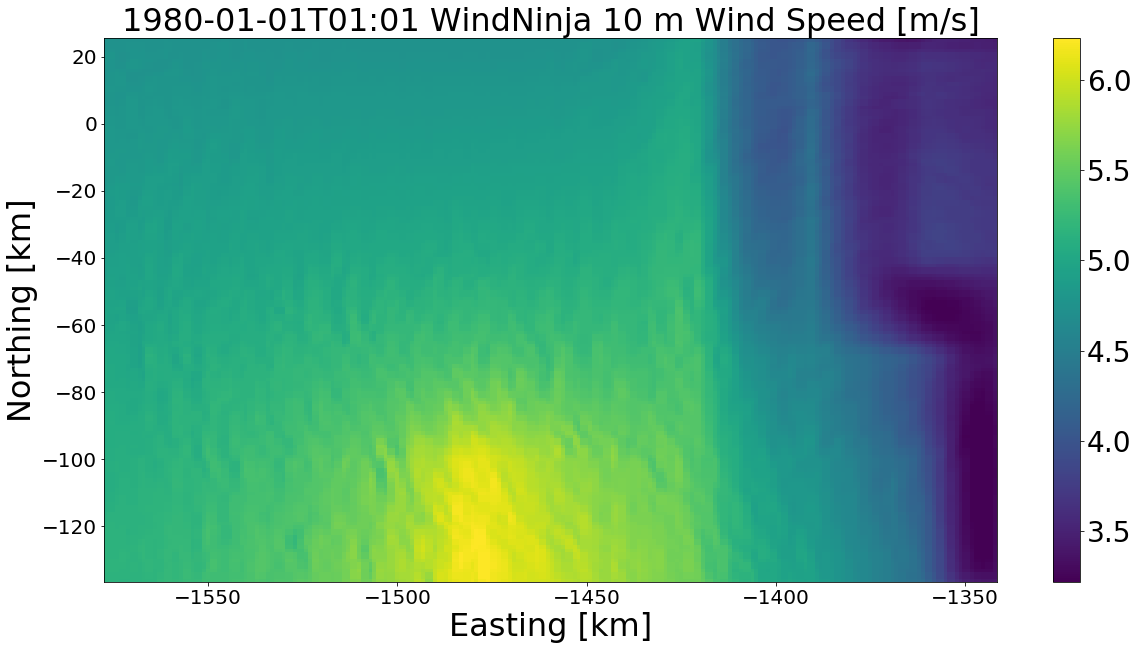

In [5]:
plt.figure(figsize=(20, 10))
plt.pcolor(wn_x, wn_y, wn_out, vmin=minima, vmax=maxima)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=28)
plt.xlim([wn_x.min(), wn_x.max()])
plt.ylim([wn_y.min(), wn_y.max()])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("Easting [km]", fontsize=32)
plt.ylabel("Northing [km]", fontsize=32)
plt.title(time_str + " WindNinja 10 m Wind Speed [m/s]", fontsize=32)
plt.savefig("figures/WN_wind_speed.pdf", dpi=100)
plt.savefig("figures/WN_wind_speed.png", dpi=100)


# Processed WindNinja

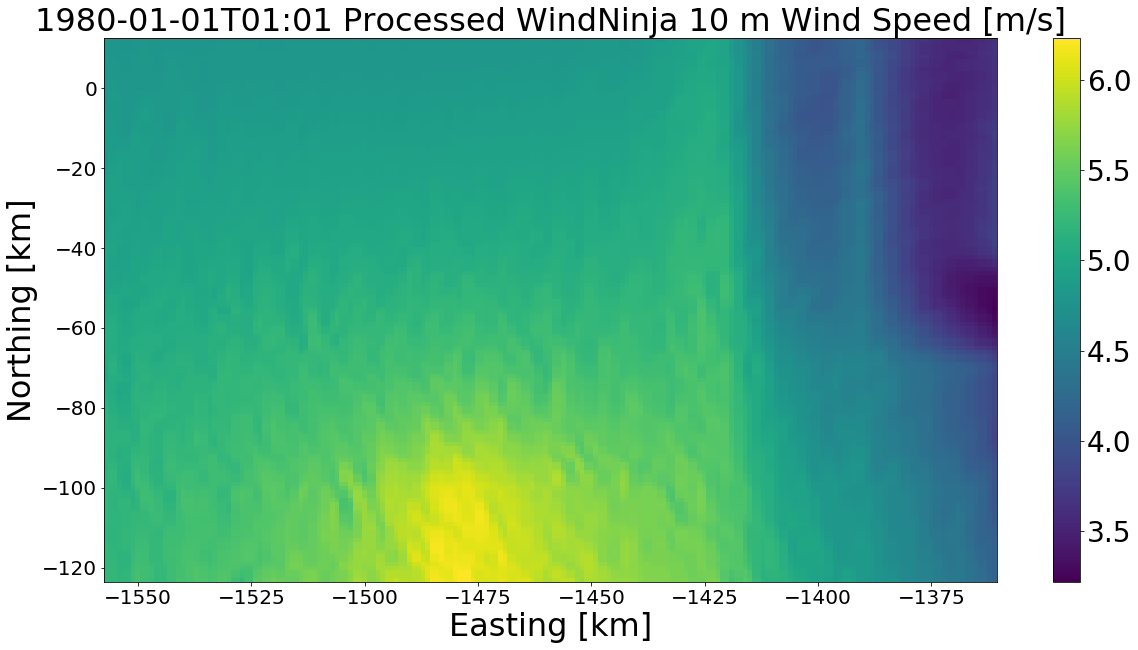

In [6]:
plt.figure(figsize=(20, 10))
plt.pcolor(wn_processed_x, wn_processed_y, wn_processed, vmin=minima, vmax=maxima)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=28)
plt.xlim([wn_processed_x.min(), wn_processed_x.max()])
plt.ylim([wn_processed_y.min(), wn_processed_y.max()])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("Easting [km]", fontsize=32)
plt.ylabel("Northing [km]", fontsize=32)
plt.title(time_str + " Processed WindNinja 10 m Wind Speed [m/s]", fontsize=32)
plt.savefig("figures/Processed_WN_wind_speed.pdf", dpi=100)
plt.savefig("figures/Processed_WN_wind_speed.png", dpi=100)

# Save processed WindNinja output to NetCDF
### Currently my kernal crashes when running this code :(. What if I use dask? 

In [ ]:
!rm nc_files/*
directory = "/scratch/summit/erke2265/antarctic-windninja/PIG/processed_output/"
months = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12"]

# Loop over each month
for j in range(0, len(months)):
    month = months[j]
    print(month)
    datasets = []

    # Loop over each timestep
    for filename in os.listdir(directory):
        if filename.startswith("1980" + month) and filename.endswith("VW.asc"):
            time_str = filename[0:10]
            date_time = pd.date_range(datetime.datetime.strptime(time_str, "%Y%m%d%H"), periods=1)
            path = directory + filename
            wn_processed = np.flipud(np.loadtxt(path, skiprows=6))
            ds = xr.Dataset(
                {
                    "Wind Speed": (["northing", "easting"], wn_processed)
                },
                coords={
                    "easting": (["easting"], 1000*wn_processed_x),
                    "northing": (["northing"], 1000*wn_processed_y),
                    "time": (["time"], date_time)
                }
            )

            datasets.append(ds)
            
    # Write a NetCDF file for each month        
    wn = xr.concat(datasets, dim='time')
    wn = wn.sortby("time", ascending=True)
    wn.to_netcdf(path="nc_files/" + month + "wn_processed.nc", mode="w")    
    
# Merge month NetCDF files into one file
wn = xr.open_mfdataset("nc_files/*wn_processed.nc")
wn = wn.sortby("time", ascending=True)
wn.to_netcdf(path="nc_files/wn_processed.nc", mode="w")  

01
02
03
04
05
06
07
08
09
10
11


In [ ]:
wn_all = xr.open_dataset("nc_files/wn_processed.nc")
time_mean = wn_all['Wind Speed'].resample(time="1D").mean().mean(dim='time')
wn_all

In [ ]:
plt.figure(figsize=(20, 10))
plt.pcolor(wn_processed_x, wn_processed_y, time_mean)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=28)
plt.xlim([wn_processed_x.min(), wn_processed_x.max()])
plt.ylim([wn_processed_y.min(), wn_processed_y.max()])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("Easting [km]", fontsize=32)
plt.ylabel("Northing [km]", fontsize=32)
plt.title("Mean 1980 WindNinja 10 m Wind Speed [m/s]", fontsize=32)
plt.savefig("figures/WN_wind_speed.pdf", dpi=100)
plt.savefig("figures/WN_wind_speed.png", dpi=100)